# Only with Google colab
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append("/content/gdrive/My Drive/Colab Notebooks")

# Imports

In [4]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential, Model, load_model
from keras.callbacks import History, ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.applications import inception_v3
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_v3_preprocessor
from keras_hist_graph import plot_history
from sklearn.metrics import confusion_matrix
import itertools

from utils import load_images, plot_accuracy_and_loss, plot_smoothed_acc_and_loss, extract_features

In [5]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (50,50))
    plt.figure(figsize = (15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

In [6]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Parameters

In [7]:
train_dir = 'dogs_299/train/'
validation_dir = 'dogs_299/validation/'
test_dir = 'dogs_299/test/'

STD_SIZE = (299, 299)
BATCH_SIZE = 20
ENVIRONNEMENT = 'local'

if ENVIRONNEMENT == 'colab':
    PATH = '/content/gdrive/My Drive/Colab Notebooks/'
else:
    PATH = ''

# 2 breeds

## Data Preparation

In [8]:
classes = ['Chihuahua', 'Japanese_spaniel']

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

with open('classes_encoding_2_breeds', 'wb') as f:
    pickle.dump(classes_labels, f)

Found 236 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 51 images belonging to 2 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel']

Loaded test images in test_features array: (51, 299, 299, 3)


# Model

In [9]:
model = load_model(PATH + 'tl_freeze_conv_base_inceptV3_data_aug_2_breeds')

C:\ProgramData\Anaconda3\envs\virtEnv\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               67109376  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 88,912,673
Trainable params: 88,878,241
Non-trainable params: 34,432
_________________________________________________________________


for i, layer in enumerate(model.layers):
   print(i, layer.name)

In [11]:
set_trainable = False
      
# choose the layers which are updated by training
layer_num = len(model.layers)
for layer in model.layers[:int(layer_num * 0.9)]:
    layer.trainable = False

for layer in model.layers[int(layer_num * 0.9):]:
    layer.trainable = True        

In [12]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_fine_tuning_inceptV3_2_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_fine_tuning_inceptV3_2_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 12s - loss: 0.0245 - acc: 0.9861 - val_loss: 4.9577e-05 - val_acc: 1.0000

Epoch 00001: val_loss improved from inf to 0.00005, saving model to tl_fine_tuning_inceptV3_2_breeds
Epoch 2/1000
 - 5s - loss: 7.0892e-04 - acc: 1.0000 - val_loss: 4.9077e-05 - val_acc: 1.0000

Epoch 00002: val_loss improved from 0.00005 to 0.00005, saving model to tl_fine_tuning_inceptV3_2_breeds
Epoch 3/1000
 - 4s - loss: 0.0296 - acc: 0.9861 - val_loss: 1.3553e-04 - val_acc: 1.0000

Epoch 00003: val_loss did not improve from 0.00005
Epoch 4/1000
 - 4s - loss: 0.1001 - acc: 0.9861 - val_loss: 6.9910e-05 - val_acc: 1.0000

Epoch 00004: val_loss did not improve from 0.00005
Epoch 5/1000
 - 4s - loss: 0.0080 - acc: 0.9955 - val_loss: 5.1790e-05 - val_acc: 1.0000

Epoch 00005: val_loss did not improve from 0.00005
Epoch 6/1000
 - 4s - loss: 0.0068 - acc: 0.9954 - val_loss: 1.0402e-09 - val_acc: 1.0000

Epoch 00006: val_loss improved from 0.00005 to 0.00000, saving model to tl_fine_tuning_inceptV3_

## Results

In [13]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

51/51 [==============================] - 2s 37ms/step


[0.029847695524156, 0.9803921580314636]

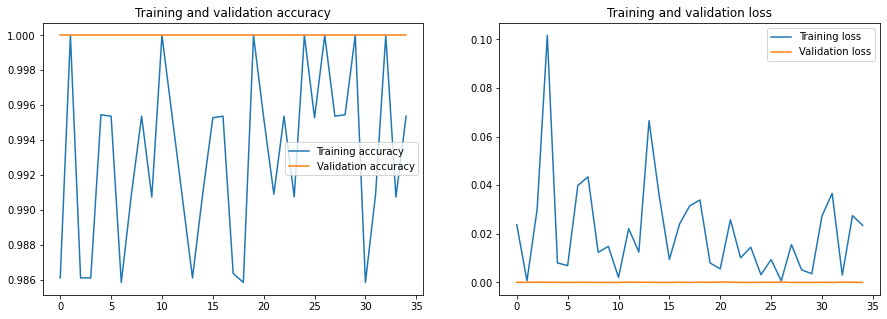

In [14]:
plot_accuracy_and_loss(history)

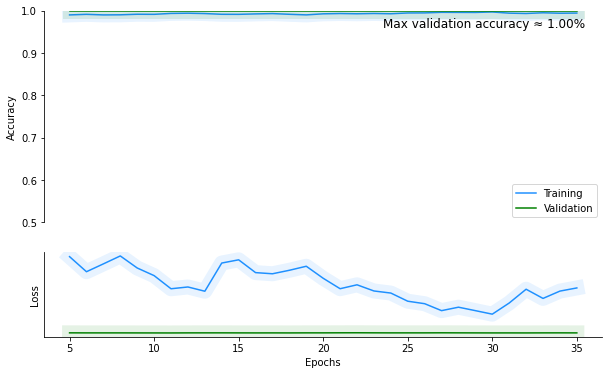

In [15]:
plot_history(history,xkcd=False)

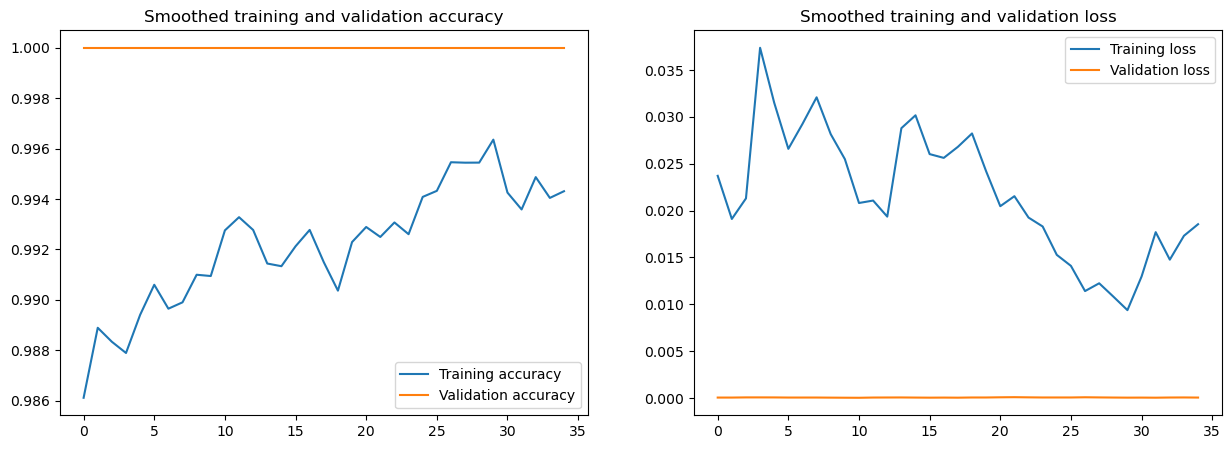

In [16]:
plot_smoothed_acc_and_loss(history, 0.8)

# 3 breeds

## Data preparation

In [17]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

with open('classes_encoding_3_breeds', 'wb') as f:
    pickle.dump(classes_labels, f)

Found 412 images belonging to 3 classes.
Found 88 images belonging to 3 classes.
Found 89 images belonging to 3 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']

Loaded test images in test_features array: (89, 299, 299, 3)


## Model

In [18]:
model = load_model(PATH + 'tl_freeze_conv_base_inceptV3_data_aug_3_breeds')

C:\ProgramData\Anaconda3\envs\virtEnv\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               67109376  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 1539      
Total params: 88,913,699
Trainable params: 88,879,267
Non-trainable params: 34,432
_________________________________________________________________


In [20]:
set_trainable = False
      
# choose the layers which are updated by training
layer_num = len(model.layers)
for layer in model.layers[:int(layer_num * 0.9)]:
    layer.trainable = False

for layer in model.layers[int(layer_num * 0.9):]:
    layer.trainable = True   

In [21]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_fine_tuning_inceptV3_3_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_fine_tuning_inceptV3_3_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 10s - loss: 0.1330 - acc: 0.9668 - val_loss: 0.2053 - val_acc: 0.9875

Epoch 00001: val_loss improved from inf to 0.20530, saving model to tl_fine_tuning_inceptV3_3_breeds
Epoch 2/1000
 - 9s - loss: 0.0484 - acc: 0.9821 - val_loss: 3.7551e-07 - val_acc: 1.0000

Epoch 00002: val_loss improved from 0.20530 to 0.00000, saving model to tl_fine_tuning_inceptV3_3_breeds
Epoch 3/1000
 - 7s - loss: 0.1009 - acc: 0.9796 - val_loss: 7.5178e-04 - val_acc: 0.9706

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/1000
 - 7s - loss: 0.1251 - acc: 0.9650 - val_loss: 1.1527e-05 - val_acc: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/1000
 - 7s - loss: 0.0443 - acc: 0.9844 - val_loss: 0.0025 - val_acc: 0.9706

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/1000
 - 7s - loss: 0.0576 - acc: 0.9821 - val_loss: 1.6093e-06 - val_acc: 0.9750

Epoch 00006: val_loss did not improve from 0.00000
Epoch 7/1000
 - 7s - loss: 0.0523 - acc: 0.9923 - val_los

## Results

In [22]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

89/89 [==============================] - 2s 23ms/step


[0.023717753138689714, 0.9775280952453613]

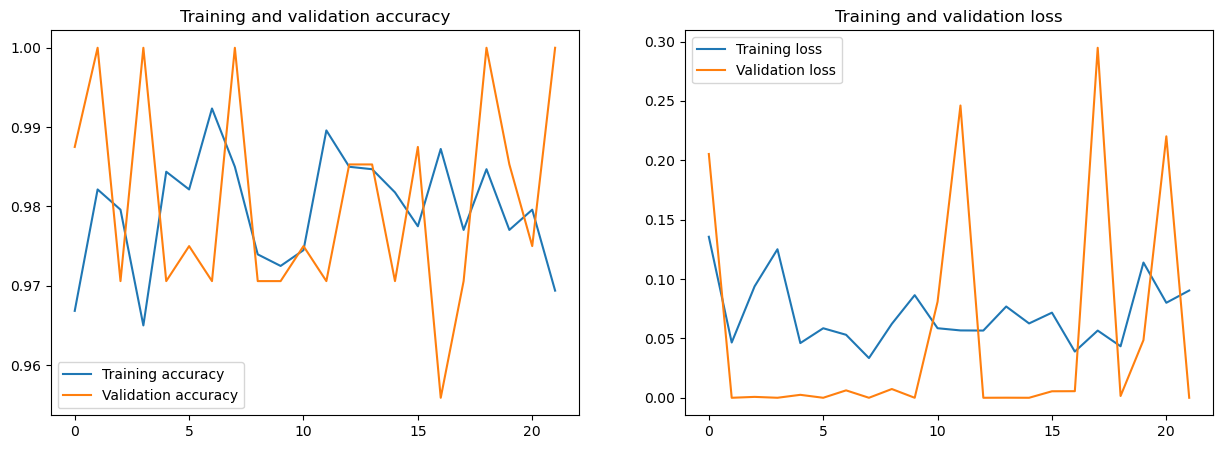

In [23]:
plot_accuracy_and_loss(history)

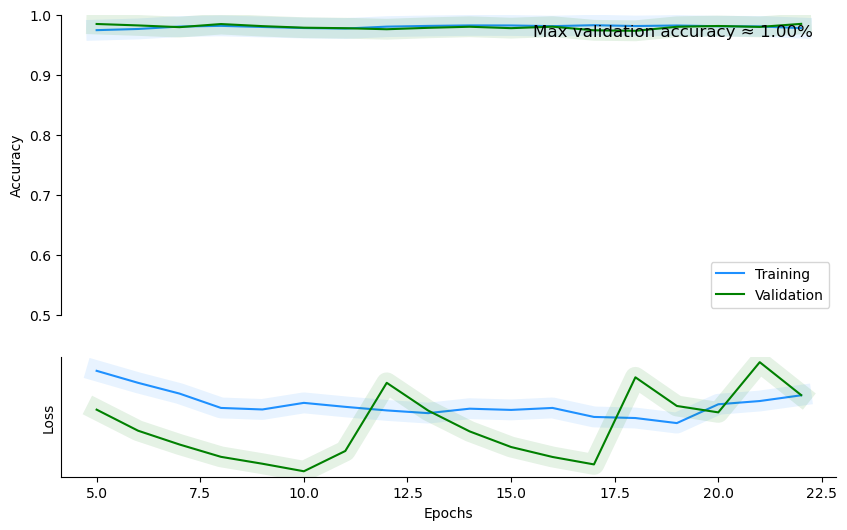

In [24]:
plot_history(history,xkcd=False)

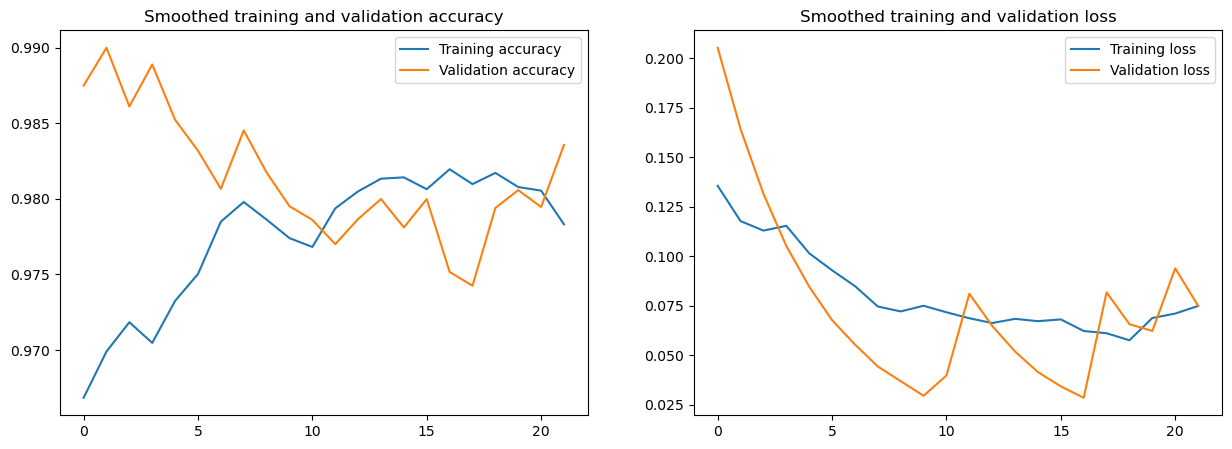

In [25]:
plot_smoothed_acc_and_loss(history, 0.8)

<Figure size 5000x5000 with 0 Axes>

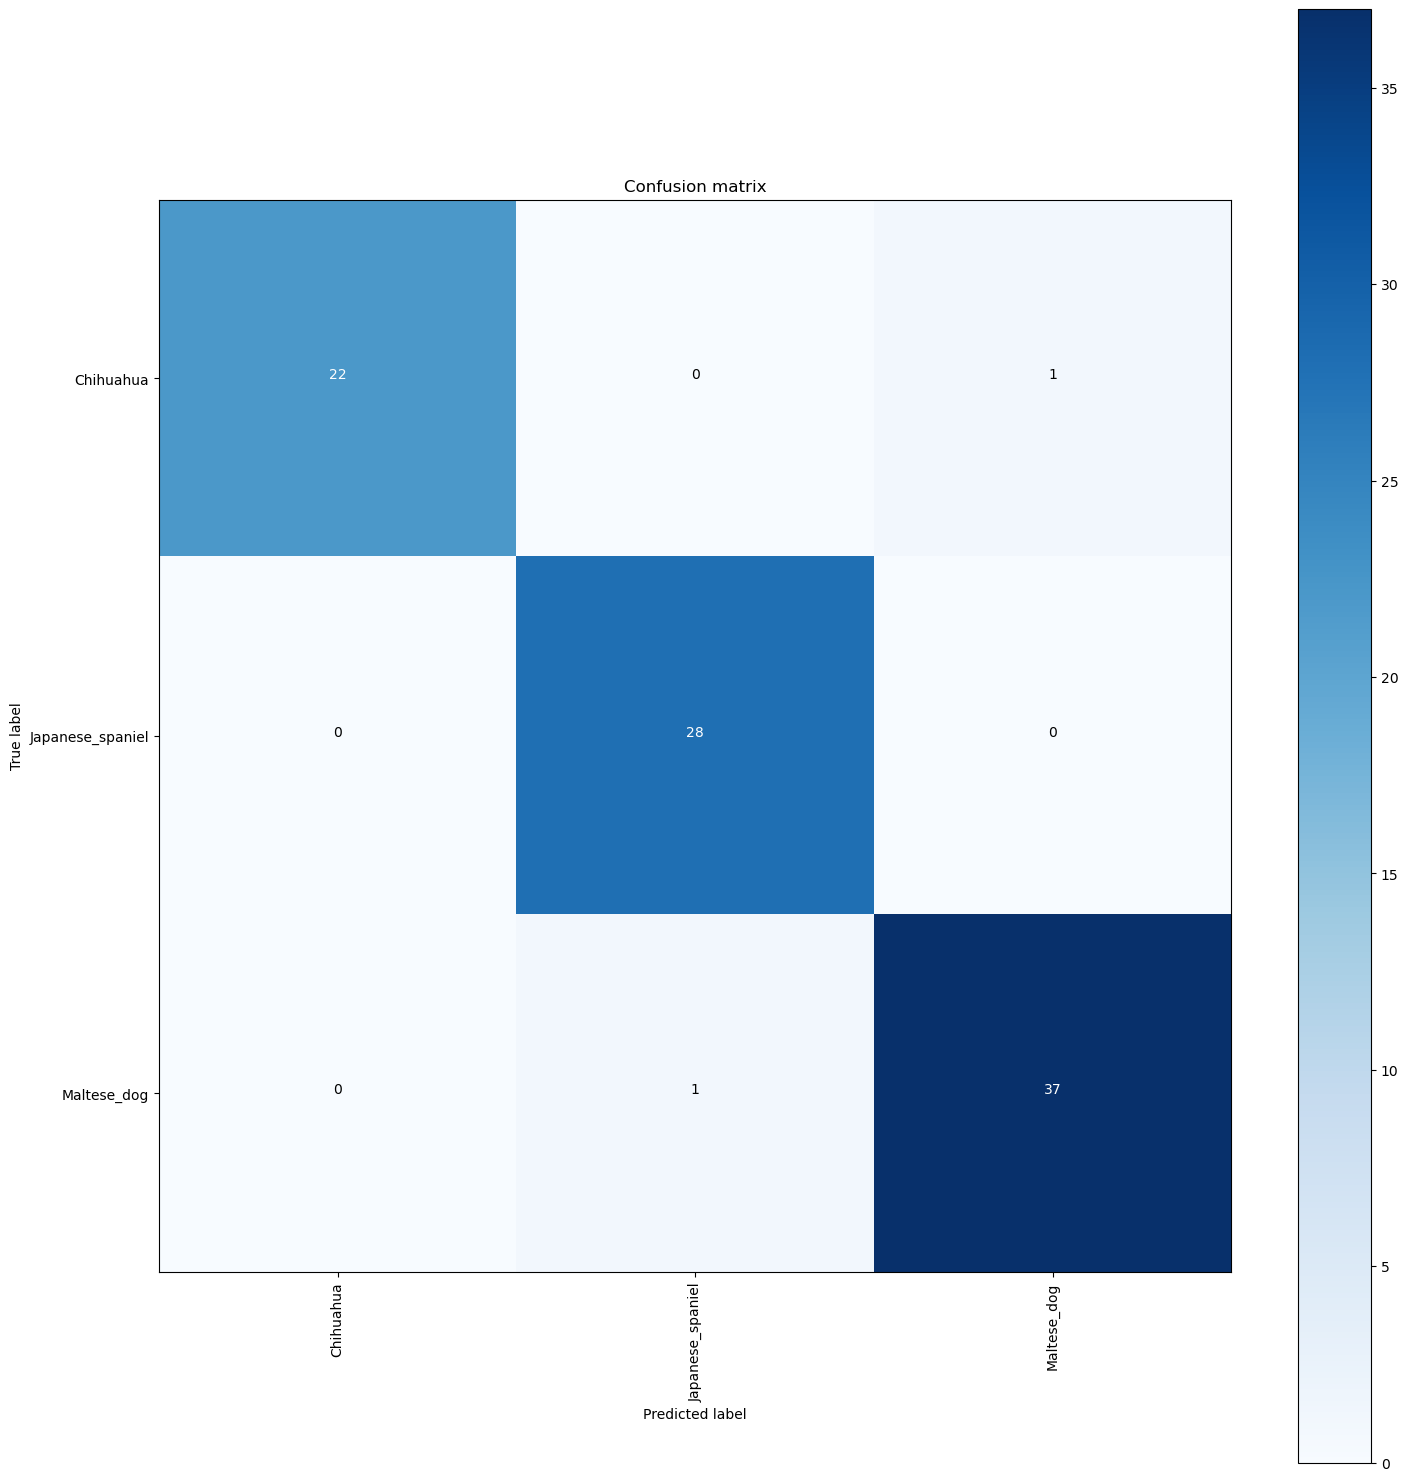

In [26]:
y_true=np.argmax(test_labels, axis=-1)
y_pred=model.predict_classes(test_features)
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, 
                      classes=classes_labels)
plt.show()

# 5 breeds

## Data preparation

In [27]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

with open('classes_encoding_5_breeds', 'wb') as f:
    pickle.dump(classes_labels, f)

Found 666 images belonging to 5 classes.
Found 143 images belonging to 5 classes.
Found 143 images belonging to 5 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']

Loaded test images in test_features array: (143, 299, 299, 3)


## Model

In [28]:
model = load_model(PATH + 'tl_freeze_conv_base_inceptV3_data_aug_5_breeds')

C:\ProgramData\Anaconda3\envs\virtEnv\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [29]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten_3 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               67109376  
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 2565      
Total params: 88,914,725
Trainable params: 88,880,293
Non-trainable params: 34,432
_________________________________________________________________


In [30]:
set_trainable = False
      
# choose the layers which are updated by training
layer_num = len(model.layers)
for layer in model.layers[:int(layer_num * 0.9)]:
    layer.trainable = False

for layer in model.layers[int(layer_num * 0.9):]:
    layer.trainable = True   

In [31]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_fine_tuning_inceptV3_5_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_fine_tuning_inceptV3_5_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 16s - loss: 0.2569 - acc: 0.9180 - val_loss: 0.0058 - val_acc: 0.9286

Epoch 00001: val_loss improved from inf to 0.00582, saving model to tl_fine_tuning_inceptV3_5_breeds
Epoch 2/1000
 - 15s - loss: 0.1911 - acc: 0.9272 - val_loss: 0.0038 - val_acc: 0.9106

Epoch 00002: val_loss improved from 0.00582 to 0.00379, saving model to tl_fine_tuning_inceptV3_5_breeds
Epoch 3/1000
 - 13s - loss: 0.1868 - acc: 0.9520 - val_loss: 0.2837 - val_acc: 0.9268

Epoch 00003: val_loss did not improve from 0.00379
Epoch 4/1000
 - 12s - loss: 0.1462 - acc: 0.9567 - val_loss: 0.0393 - val_acc: 0.9512

Epoch 00004: val_loss did not improve from 0.00379
Epoch 5/1000
 - 13s - loss: 0.1542 - acc: 0.9396 - val_loss: 0.1038 - val_acc: 0.9350

Epoch 00005: val_loss did not improve from 0.00379
Epoch 6/1000
 - 13s - loss: 0.2155 - acc: 0.9211 - val_loss: 0.6177 - val_acc: 0.9187

Epoch 00006: val_loss did not improve from 0.00379
Epoch 7/1000
 - 12s - loss: 0.1856 - acc: 0.9334 - val_loss: 0.2985 

## Results

In [32]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

143/143 [==============================] - 1s 7ms/step


[0.22752919682788816, 0.9580419659614563]

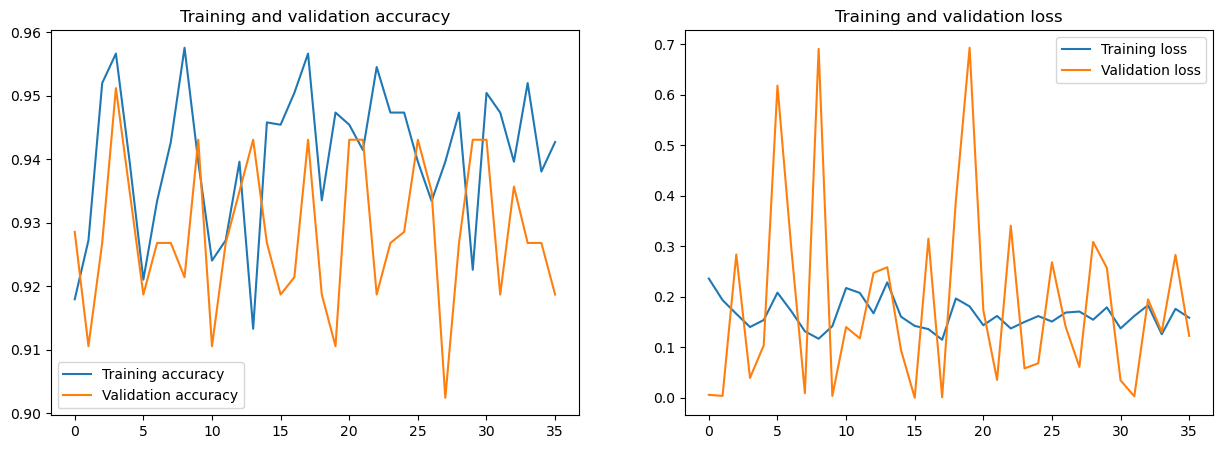

In [33]:
plot_accuracy_and_loss(history)

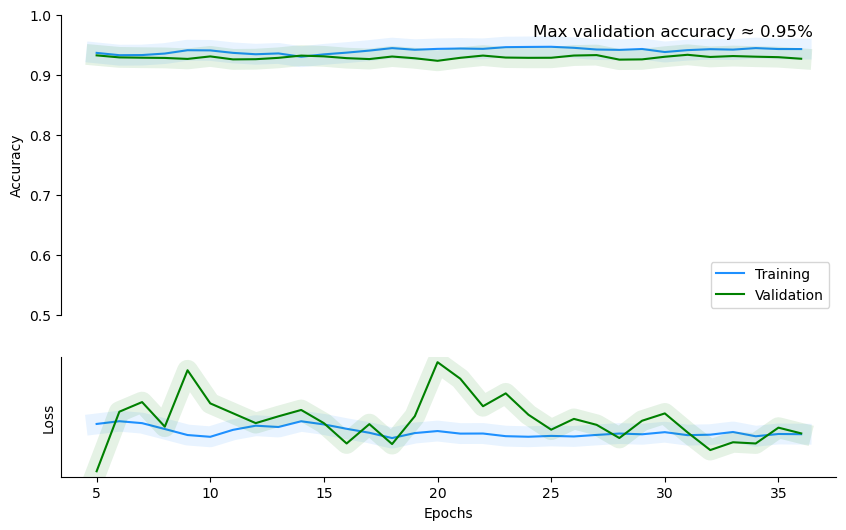

In [34]:
plot_history(history,xkcd=False)

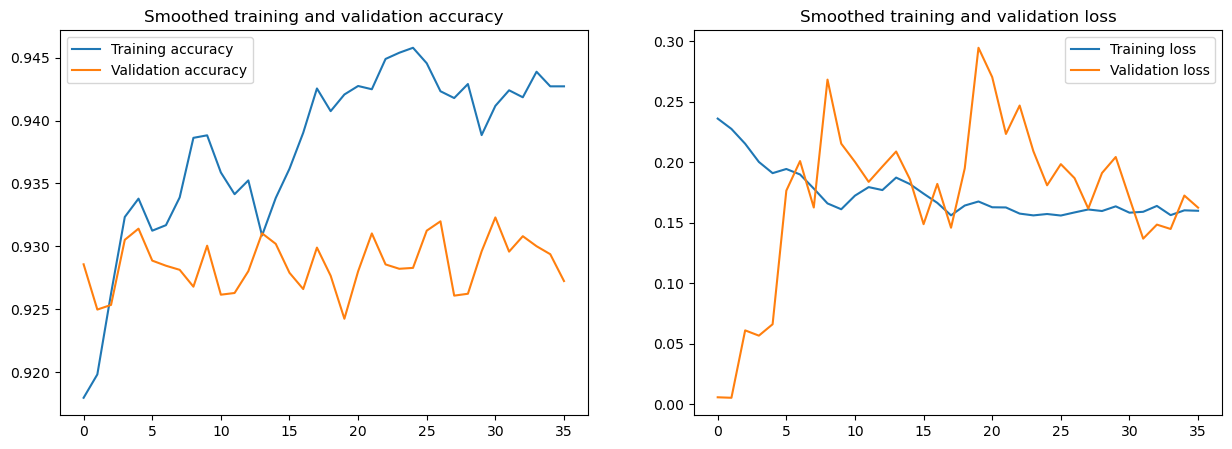

In [35]:
plot_smoothed_acc_and_loss(history, 0.8)

<Figure size 5000x5000 with 0 Axes>

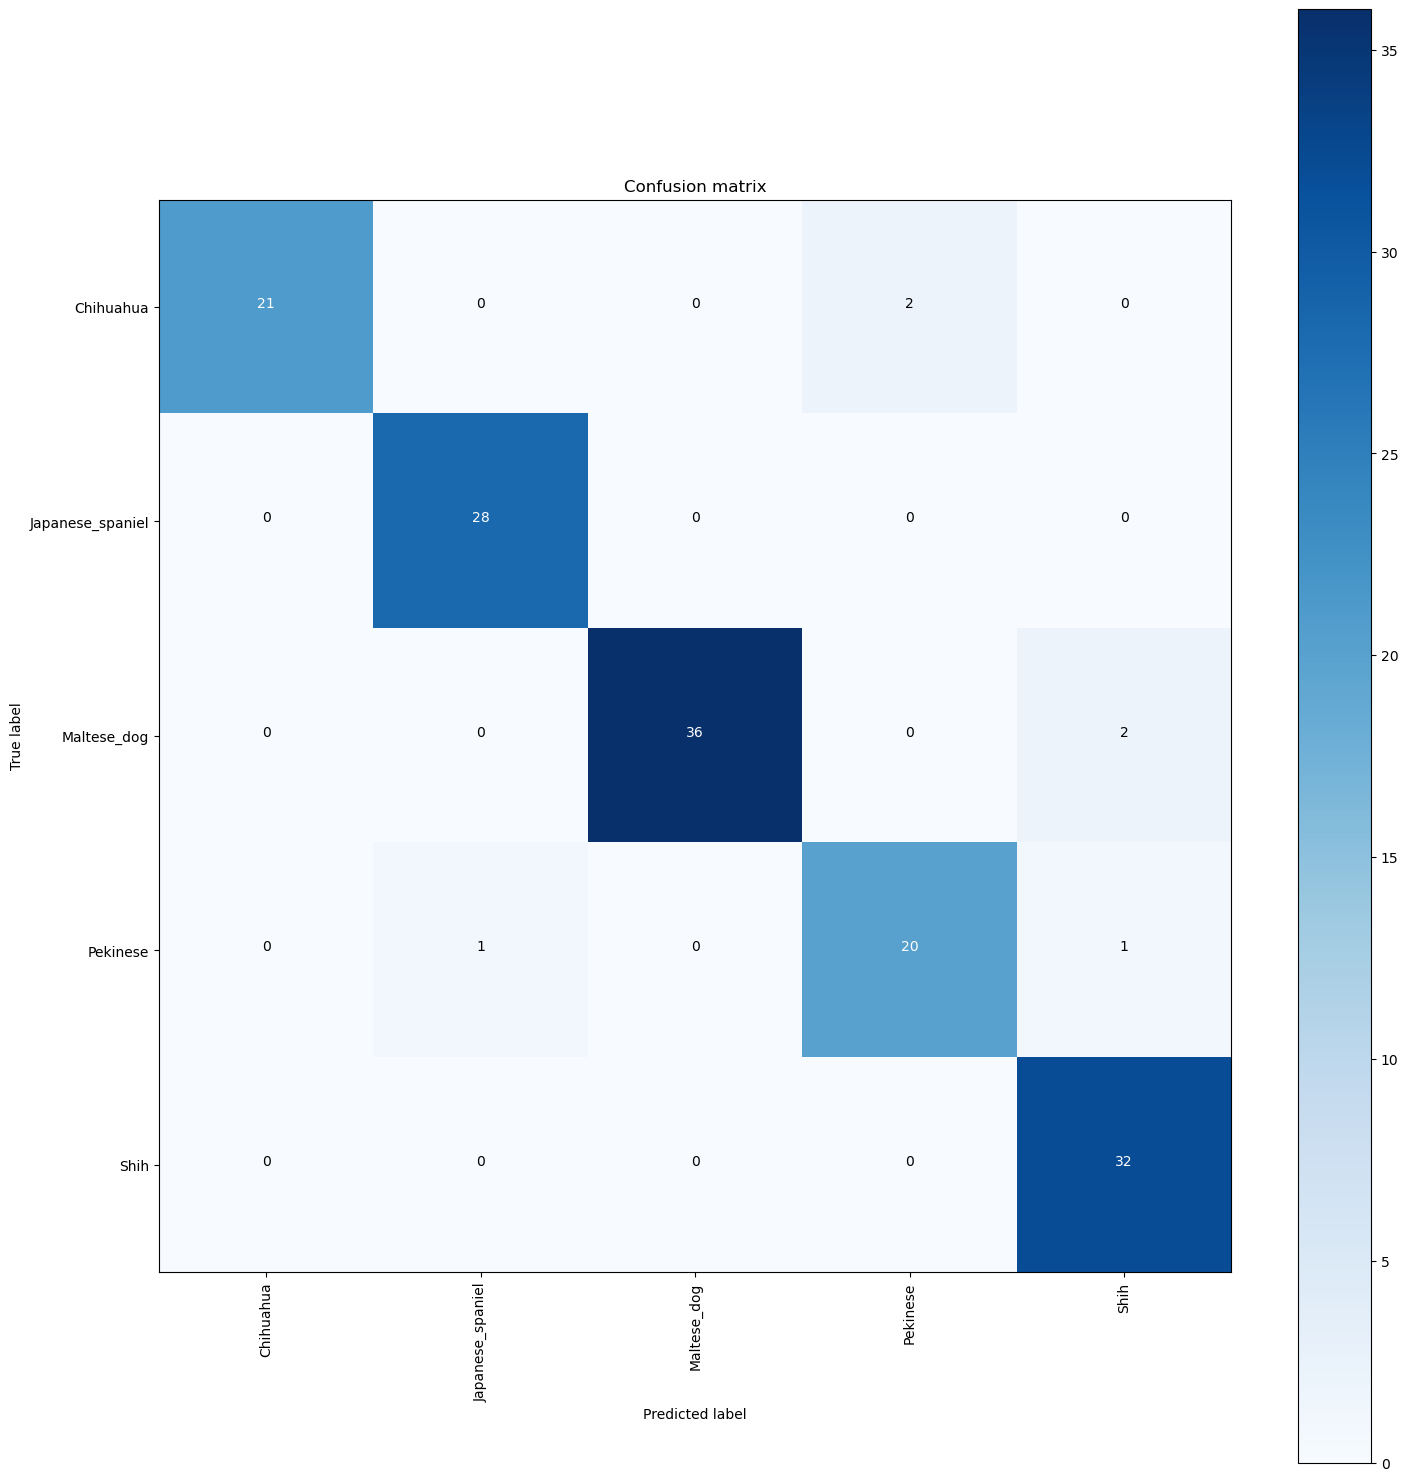

In [36]:
y_true=np.argmax(test_labels, axis=-1)
y_pred=model.predict_classes(test_features)
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, 
                      classes=classes_labels)
plt.show()

# 60 breeds

## Data preparation

In [37]:
classes = os.listdir(PATH + train_dir)[:60]

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

with open('classes_encoding_60_breeds', 'wb') as f:
    pickle.dump(classes_labels, f)

Found 7072 images belonging to 60 classes.
Found 1527 images belonging to 60 classes.
Found 1512 images belonging to 60 classes.

Stored classes labels in classes_labels:  ['affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'basenji', 'basset', 'beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'black', 'Blenheim_spaniel', 'bloodhound', 'bluetick', 'Border_collie', 'Border_terrier', 'borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'boxer', 'Brabancon_griffon', 'briard', 'Brittany_spaniel', 'bull_mastiff', 'cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly', 'Dandie_Dinmont', 'dhole', 'dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'flat', 'French_bulldog', 'German_shepherd', 'German_short', 'giant_schnauzer', 'golden_retriever', 'Gordon_setter', 'Greater_Swiss_Mountain_do

## Model

In [38]:
model = load_model(PATH + 'tl_freeze_conv_base_data_inceptV3_aug_60_breeds')

C:\ProgramData\Anaconda3\envs\virtEnv\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [39]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten_4 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               67109376  
_________________________________________________________________
dense_8 (Dense)              (None, 60)                30780     
Total params: 88,942,940
Trainable params: 88,908,508
Non-trainable params: 34,432
_________________________________________________________________


In [40]:
set_trainable = False
      
# choose the layers which are updated by training
layer_num = len(model.layers)
for layer in model.layers[:int(layer_num * 0.9)]:
    layer.trainable = False

for layer in model.layers[int(layer_num * 0.9):]:
    layer.trainable = True   

In [41]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_fine_tuning_inceptV3_60_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_fine_tuning_60_inceptV3_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 145s - loss: 0.6430 - acc: 0.8425 - val_loss: 0.0272 - val_acc: 0.9296

Epoch 00001: val_loss improved from inf to 0.02722, saving model to tl_fine_tuning_inceptV3_60_breeds
Epoch 2/1000
 - 142s - loss: 0.5912 - acc: 0.8518 - val_loss: 0.5775 - val_acc: 0.9277

Epoch 00002: val_loss did not improve from 0.02722
Epoch 3/1000
 - 137s - loss: 0.5308 - acc: 0.8636 - val_loss: 0.0519 - val_acc: 0.9283

Epoch 00003: val_loss did not improve from 0.02722
Epoch 4/1000
 - 135s - loss: 0.5230 - acc: 0.8667 - val_loss: 0.0802 - val_acc: 0.9283

Epoch 00004: val_loss did not improve from 0.02722
Epoch 5/1000
 - 135s - loss: 0.5255 - acc: 0.8637 - val_loss: 0.3021 - val_acc: 0.9323

Epoch 00005: val_loss did not improve from 0.02722
Epoch 6/1000
 - 135s - loss: 0.4939 - acc: 0.8744 - val_loss: 0.8359 - val_acc: 0.9297

Epoch 00006: val_loss did not improve from 0.02722
Epoch 7/1000
 - 135s - loss: 0.5472 - acc: 0.8625 - val_loss: 0.0975 - val_acc: 0.9250

Epoch 00007: val_loss did n

## Results

In [42]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

1512/1512 [==============================] - 14s 9ms/step


[0.4157166619841798, 0.9212962985038757]

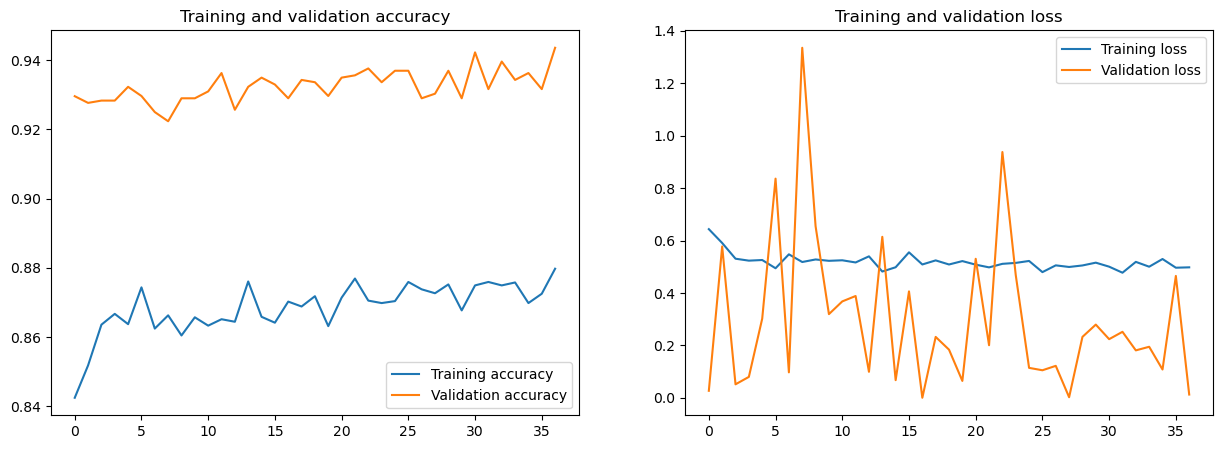

In [43]:
plot_accuracy_and_loss(history)

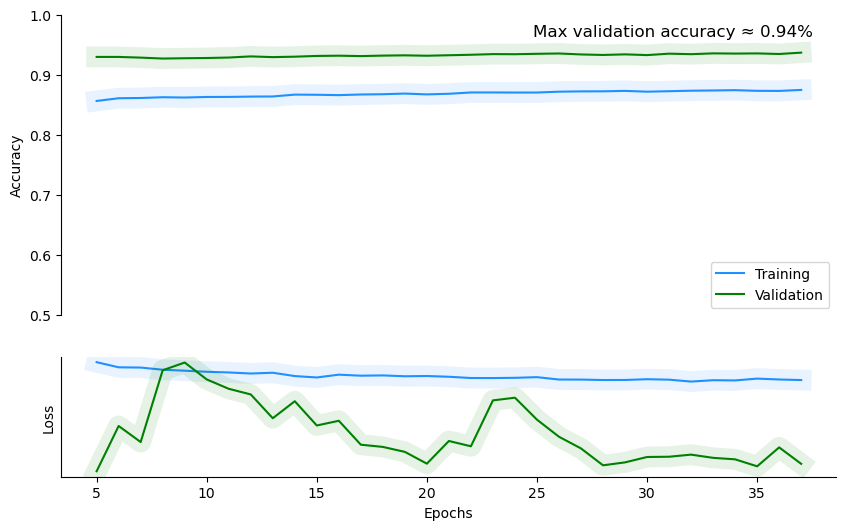

In [44]:
plot_history(history,xkcd=False)

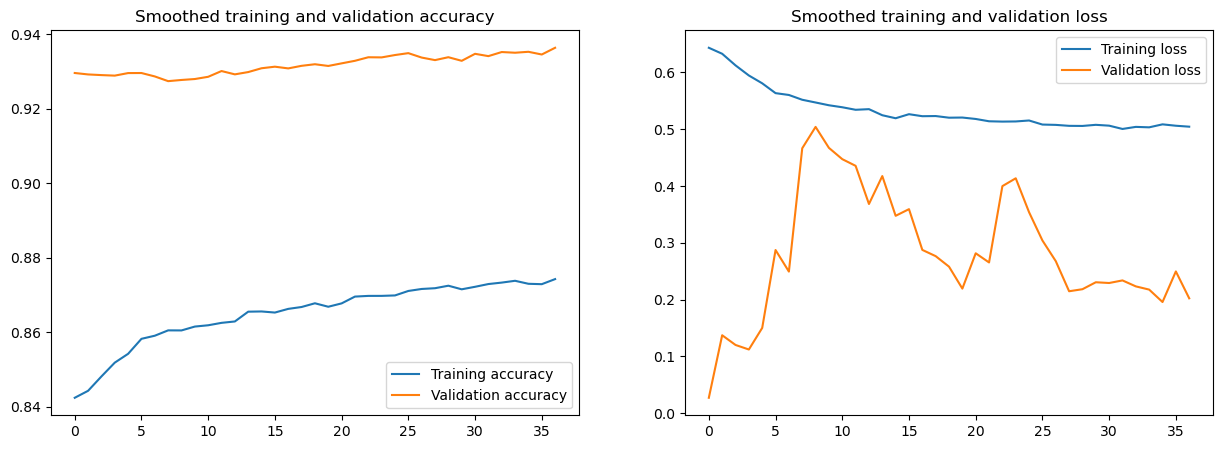

In [45]:
plot_smoothed_acc_and_loss(history, 0.8)

<Figure size 5000x5000 with 0 Axes>

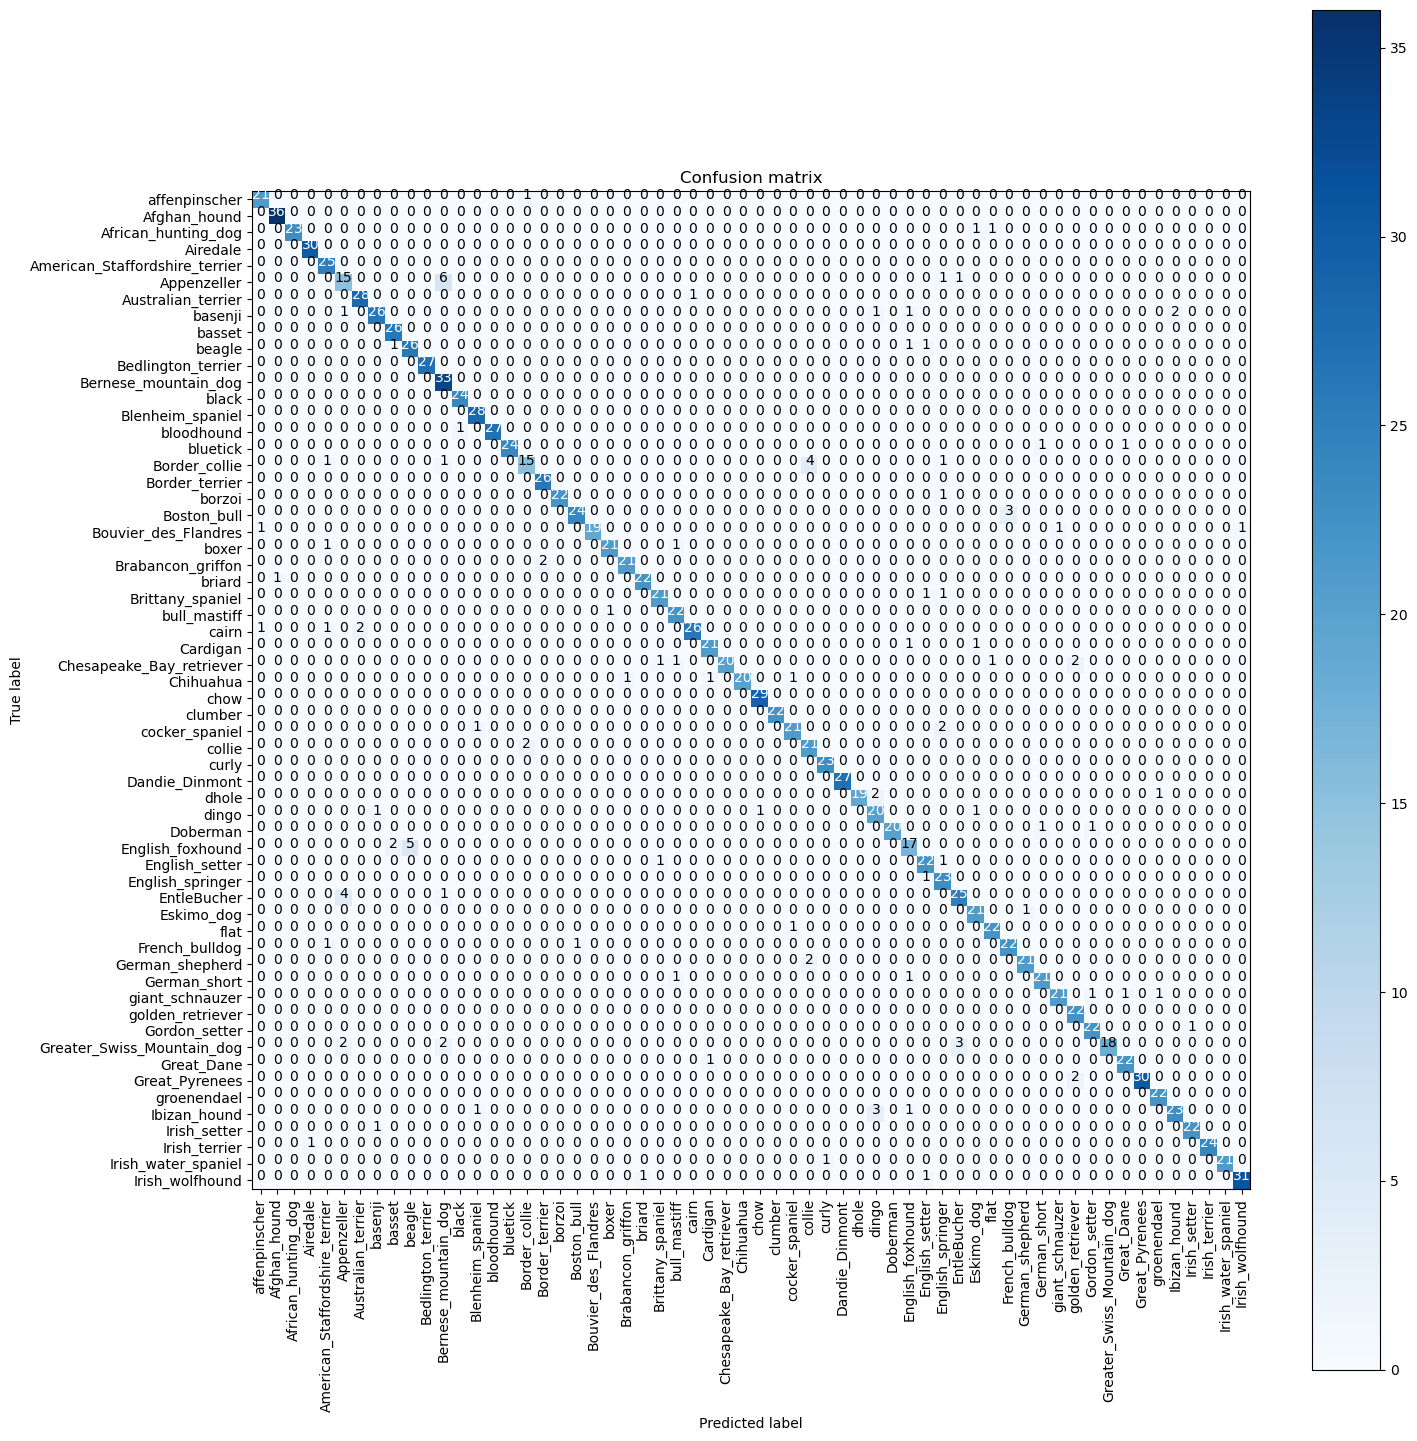

In [46]:
y_true=np.argmax(test_labels, axis=-1)
y_pred=model.predict_classes(test_features)
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, 
                      classes=classes_labels)
plt.show()

# 120 breeds

## Data preparation

In [47]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

with open('classes_encoding_120_breeds', 'wb') as f:
    pickle.dump(classes_labels, f)

Found 14397 images belonging to 120 classes.
Found 3099 images belonging to 120 classes.
Found 3084 images belonging to 120 classes.

Stored classes labels in classes_labels:  ['Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd', 'German_short', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', '

# Model

In [48]:
model = load_model(PATH + 'tl_freeze_conv_base_inceptV3_data_aug_120_breeds')

C:\ProgramData\Anaconda3\envs\virtEnv\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [49]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten_5 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               67109376  
_________________________________________________________________
dense_10 (Dense)             (None, 120)               61560     
Total params: 88,973,720
Trainable params: 88,939,288
Non-trainable params: 34,432
_________________________________________________________________


In [50]:
set_trainable = False
      
# choose the layers which are updated by training
layer_num = len(model.layers)
for layer in model.layers[:int(layer_num * 0.9)]:
    layer.trainable = False

for layer in model.layers[int(layer_num * 0.9):]:
    layer.trainable = True   

In [51]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_fine_tuning_inceptV3_120_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_fine_tuning_inceptV3_120_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 289s - loss: 1.1915 - acc: 0.7544 - val_loss: 0.9468 - val_acc: 0.8669

Epoch 00001: val_loss improved from inf to 0.94679, saving model to tl_fine_tuning_inceptV3_120_breeds
Epoch 2/1000
 - 279s - loss: 1.1182 - acc: 0.7671 - val_loss: 1.0567 - val_acc: 0.8668

Epoch 00002: val_loss did not improve from 0.94679
Epoch 3/1000
 - 277s - loss: 1.1110 - acc: 0.7745 - val_loss: 0.9906 - val_acc: 0.8681

Epoch 00003: val_loss did not improve from 0.94679
Epoch 4/1000
 - 277s - loss: 1.0893 - acc: 0.7764 - val_loss: 0.9142 - val_acc: 0.8672

Epoch 00004: val_loss improved from 0.94679 to 0.91418, saving model to tl_fine_tuning_inceptV3_120_breeds
Epoch 5/1000
 - 277s - loss: 1.1141 - acc: 0.7736 - val_loss: 0.1285 - val_acc: 0.8668

Epoch 00005: val_loss improved from 0.91418 to 0.12850, saving model to tl_fine_tuning_inceptV3_120_breeds
Epoch 6/1000
 - 278s - loss: 1.1134 - acc: 0.7711 - val_loss: 1.9327 - val_acc: 0.8691

Epoch 00006: val_loss did not improve from 0.12850
Ep

## Results

In [52]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

3084/3084 [==============================] - 33s 11ms/step


[1.0357739660361447, 0.8712710738182068]

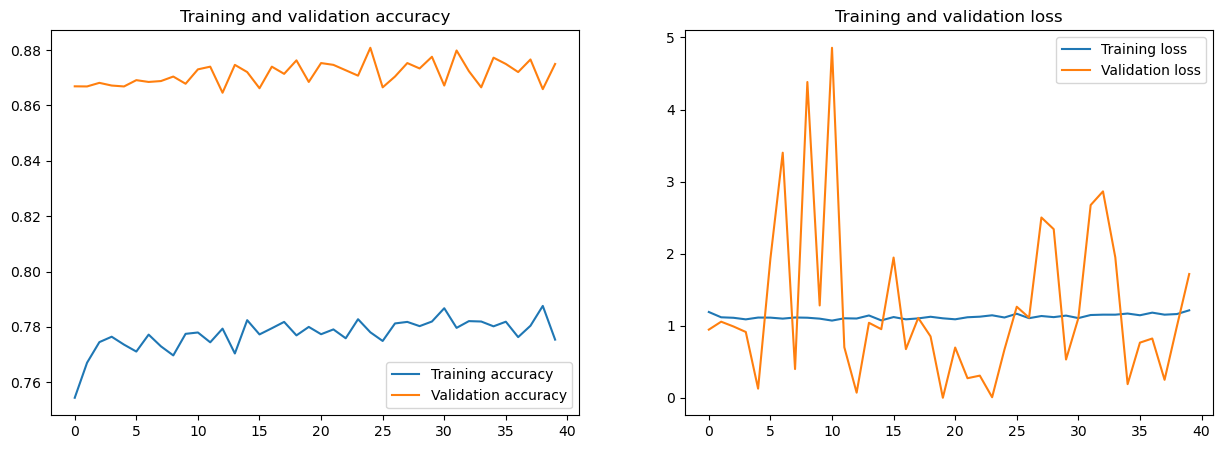

In [53]:
plot_accuracy_and_loss(history)

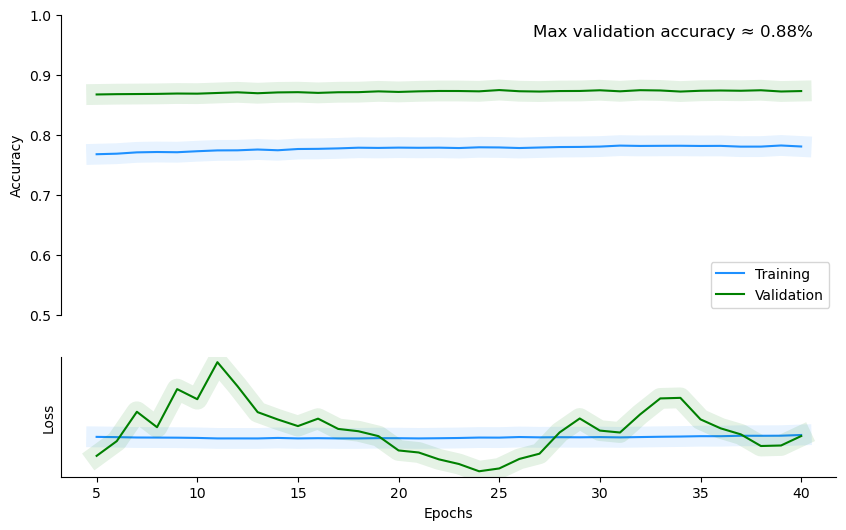

In [54]:
plot_history(history,xkcd=False)

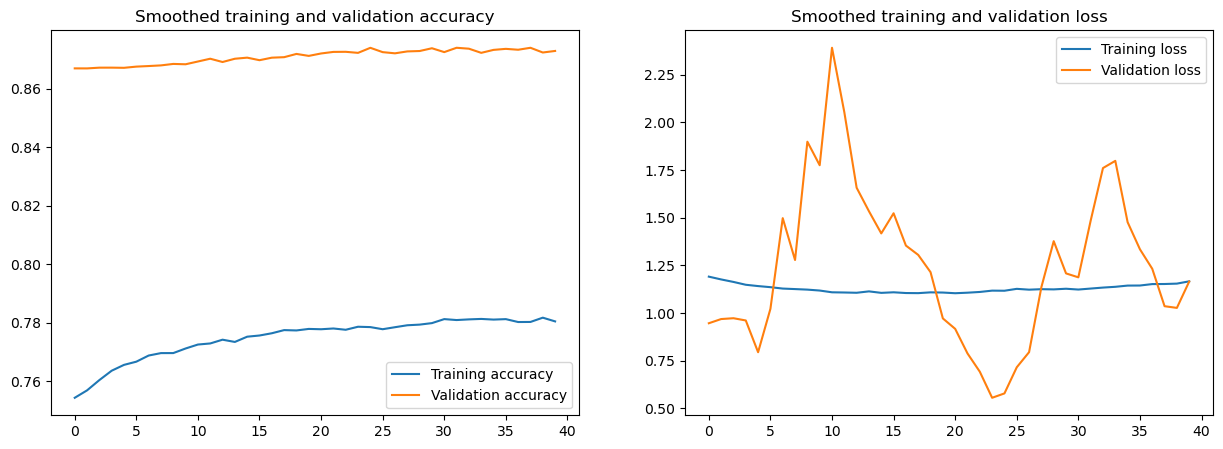

In [55]:
plot_smoothed_acc_and_loss(history, 0.8)

<Figure size 5000x5000 with 0 Axes>

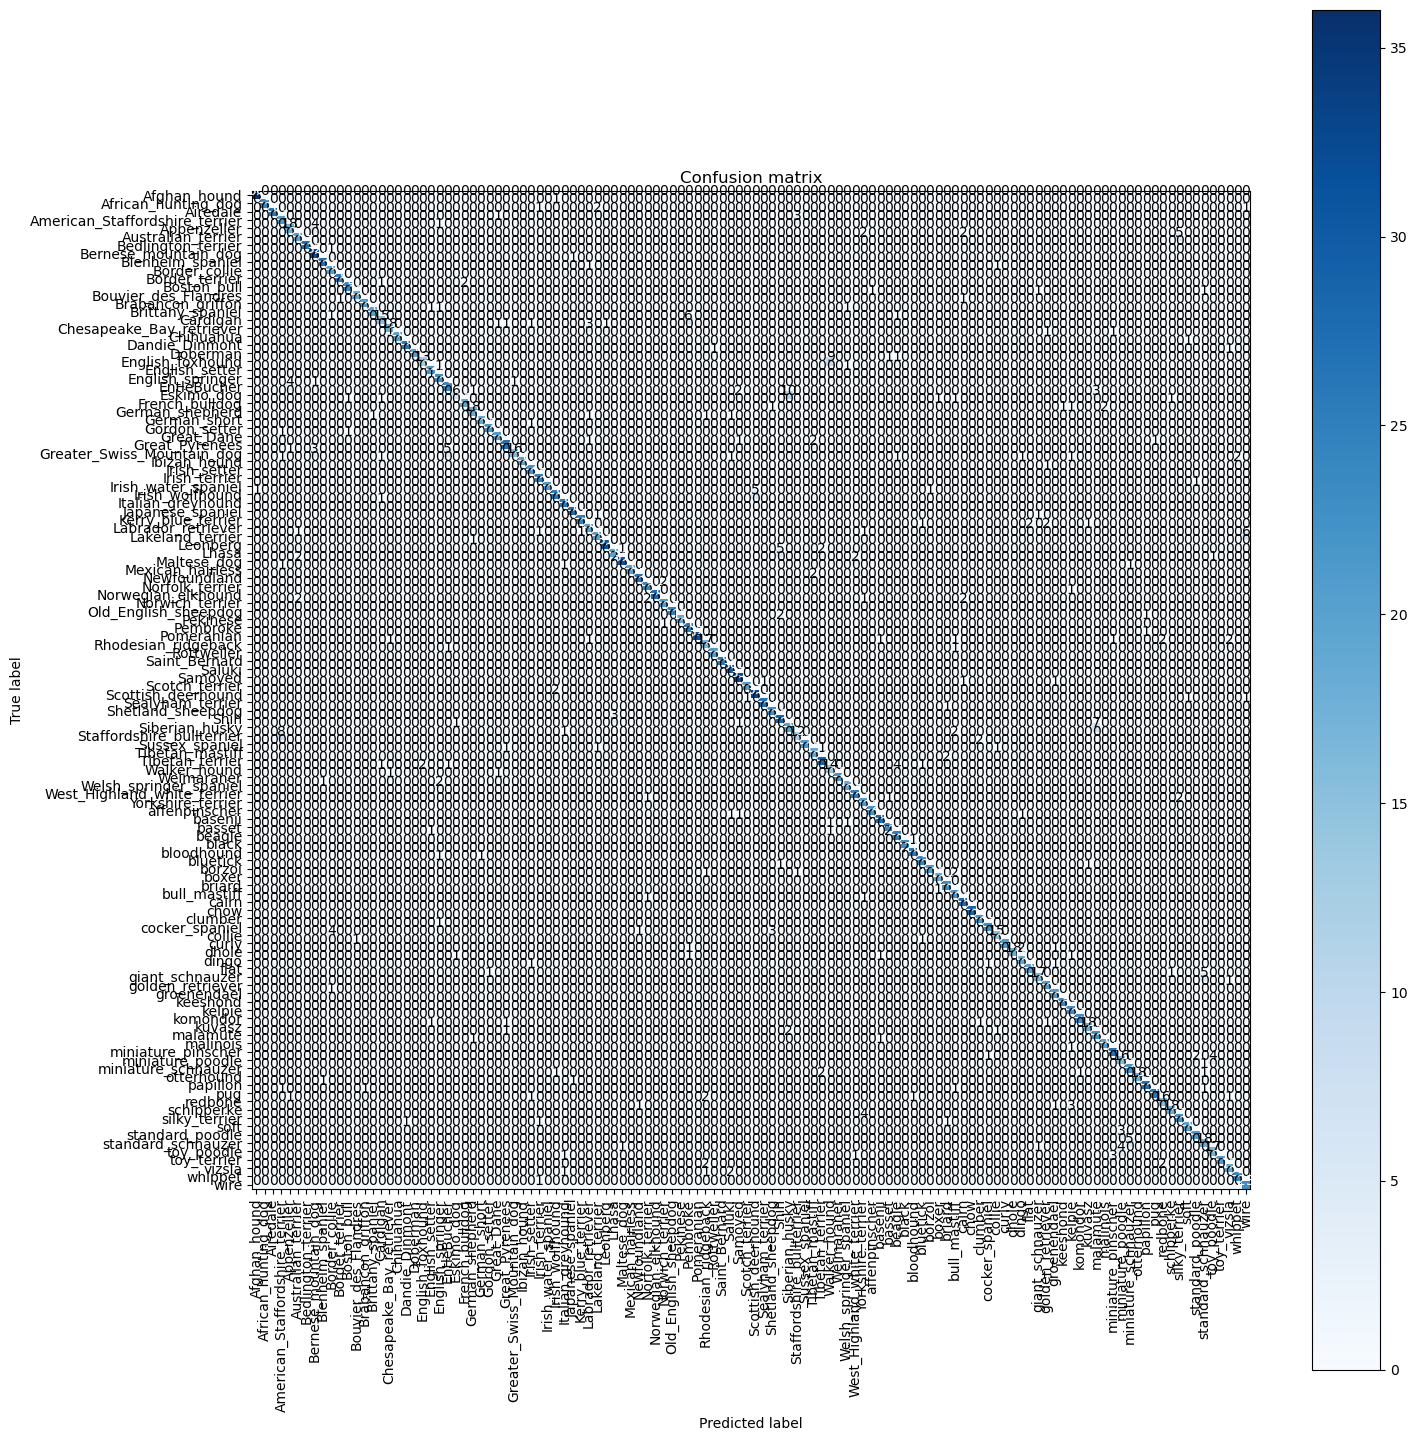

In [56]:
y_true=np.argmax(test_labels, axis=-1)
y_pred=model.predict_classes(test_features)
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, 
                      classes=classes_labels)
plt.show()